# Energy term computations

Sometimes it is necessary to compute certain properties of energy terms, such as energy, effective field, or energy density, without driving the system and updating magnetisation field.

As usual, we start by importing the modules we are going to use:

In [1]:
import oommfc as mc
import discretisedfield as df
import micromagneticmodel as mm

We define a cube mesh with edge length $10 \,\text{nm}$ and cell discretisation edge $1 \,\text{nm}$.

In [2]:
region = df.Region(p1=(0, 0, 0), p2=(10e-9, 10e-9, 10e-9))
mesh = df.Mesh(region=region, n=(10, 10, 10))
mesh.k3d()

Output()

Now we define the system object and its energy equation.

In [3]:
system = mm.System(name='energy_computations')

A = 1e-11  # exchange energy constant (J/m)
H = (0.1/mm.consts.mu0, 0, 0)  # external magnetic field (A/m)
K = 1e3  # uniaxial anisotropy constant (J/m3)
u = (1, 1, 1)  # uniaxial anisotropy axis

system.energy = (mm.Exchange(A=A) +
                 mm.Demag() +
                 mm.Zeeman(H=H) +
                 mm.UniaxialAnisotropy(K=K, u=u))

system.energy

Exchange(A=1e-11) + Demag() + Zeeman(H=(79577.47154594767, 0, 0)) + UniaxialAnisotropy(K=1000.0, u=(1, 1, 1))

We will now intialise the magnetisation in the $(0, 0, 1)$ direction with $M_\text{s} = 8\times 10^{5} \,\text{A/m}$ and relax the magnetisation.

In [4]:
Ms = 8e5  # saturation magnetisation (A/m)

system.m = df.Field(mesh, dim=3, value=(0, 0, 1), norm=Ms)

All computations are performed using `mc.compute`, where `mc` is the micromagnetic calculator we choose at import. `compute` function takes two arguments:

1. Property we want to compute
2. System object

For instance, total effective field is:

Running OOMMF (ExeOOMMFRunner) [2020/07/02 13:23]... (2.0 s)


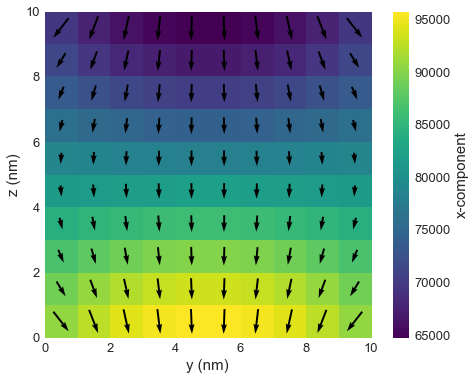

In [5]:
Heff = mc.compute(system.energy.effective_field, system)
Heff.plane('x').mpl()

Similarly, the effective field of an individual energy term is:

In [6]:
Hex_eff = mc.compute(system.energy.exchange.effective_field, system)

Running OOMMF (ExeOOMMFRunner) [2020/07/02 13:23]... (1.8 s)


Because we initialised the system with the uniform state, we expect this effective field to be zero.

In [7]:
Hex_eff.average

(0.0, 0.0, 0.0)

The energy density is:

Running OOMMF (ExeOOMMFRunner) [2020/07/02 13:23]... (1.9 s)


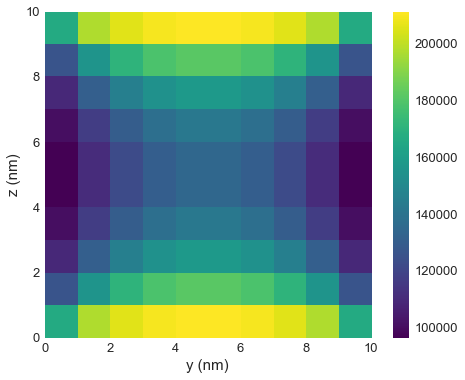

In [8]:
w = mc.compute(system.energy.density, system)
w.plane('x').mpl()

Similarly, the energy (volume integral of energy density) is:

In [9]:
E = mc.compute(system.energy.energy, system)
print(f'The energy of the system is {E} J.')

Running OOMMF (ExeOOMMFRunner) [2020/07/02 13:24]... (1.8 s)
The energy of the system is 1.3470795322e-19 J.


Now, we can relax the system.

In [10]:
md = mc.MinDriver()
md.drive(system)

Running OOMMF (ExeOOMMFRunner) [2020/07/02 13:24]... (2.1 s)


If we now compute the energy, we can show that the energy decreased:

In [11]:
E = mc.compute(system.energy.energy, system)
print(f'The energy of the system is {E} J.')

Running OOMMF (ExeOOMMFRunner) [2020/07/02 13:24]... (1.8 s)
The energy of the system is 1.3470795322e-19 J.


The relaxed magnetisation is:

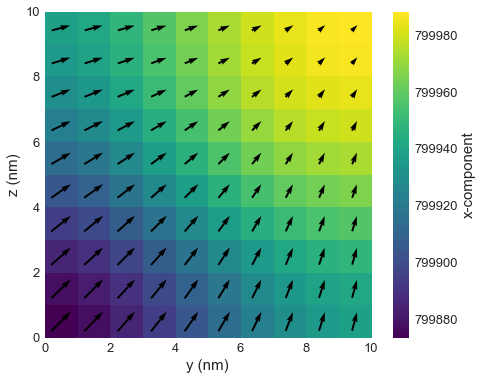

In [12]:
system.m.plane('x').mpl()

The exchange energy is:

In [13]:
mc.compute(system.energy.exchange.energy, system)

Running OOMMF (ExeOOMMFRunner) [2020/07/02 13:24]... (1.9 s)


1.12170206436e-21

We can also check the sum of all individual energy terms and check if it the same as the total energy.

In [14]:
total_energy = 0
for term in system.energy:
    total_energy += mc.compute(term.energy, system)
  
E = mc.compute(system.energy.energy, system)
# A simpler way:
# E = sum([mc.compute(getattr(term, 'energy'), system) for term in system.energy])
    
print(f'The sum of energy terms is {total_energy} J.')
print(f'The energy of the system is {E} J.')

Running OOMMF (ExeOOMMFRunner) [2020/07/02 13:24]... (1.7 s)
Running OOMMF (ExeOOMMFRunner) [2020/07/02 13:24]... (1.7 s)
Running OOMMF (ExeOOMMFRunner) [2020/07/02 13:24]... (1.7 s)
Running OOMMF (ExeOOMMFRunner) [2020/07/02 13:24]... (1.7 s)
Running OOMMF (ExeOOMMFRunner) [2020/07/02 13:24]... (1.7 s)
The sum of energy terms is 5.352855331433802e-20 J.
The energy of the system is 5.35285533145e-20 J.
